In [1]:
import rasterio as rs
import rasterio.merge as rsmerge
from rasterio.plot import show
from rasterio.windows import Window

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

import os
from os.path import dirname, abspath, join

import numpy as np
import numpy

import requests
import json


In [2]:
class HouseViz():
    def __init__(self):
        """
        The class HouseViz, initializes with both local path and metadata variables.
        """
        # location
        self.current_url = os.getcwd()
        self.home_url = dirname(abspath(self.current_url))
        self.data_url = os.path.join(self.home_url, 'Data')
        self.dtm_url = os.path.join(self.data_url, 'DTM')
        self.dsm_url = os.path.join(self.data_url, 'DSM')
        self.dtm_tiff_url = os.path.join(self.dtm_url, 'GeoTiff')
        self.dsm_tiff_url = os.path.join(self.dsm_url, 'GeoTiff')
        
        # map, metadata.
        self.map_size = (32000.0, 20000.0)
        self.maps = {
            '01' : (130000.0, 247000.0),
            '02' : (162000.0, 247000.0),
            '03' : (194000.0, 247000.0),
            '04' : (34000.0, 238000.0),
            '05' : (66000.0, 238000.0),
            '06' : (98000.0, 238000.0),
            '07' : (130000.0, 238000.0),
            '08' : (162000.0, 238000.0),
            '09' : (194000.0, 238000.0),
            '10' : (226000.0, 238000.0),
            '11' : (2000.0, 218000.0),
            '12' : (34000.0, 218000.0),
            '13' : (66000.0, 218000.0),
            '14' : (98000.0, 218000.0),
            '15' : (130000.0, 218000.0),
            '16' : (162000.0, 218000.0),
            '17' : (194000.0, 218000.0),
            '18' : (226000.0, 218000.0),
            '19' : (2000.0, 198000.0),
            '20' : (34000.0, 198000.0),
            '21' : (66000.0, 198000.0),
            '22' : (98000.0, 198000.0),
            '23' : (130000.0, 198000.0),
            '24' : (162000.0, 198000.0),
            '25' : (194000.0, 198000.0),
            '26' : (226000.0, 198000.0),
            '27' : (2000.0, 178000.0),
            '28' : (34000.0, 178000.0),
            '29' : (66000.0, 178000.0),
            '30' : (98000.0, 178000.0),
            '31' : (130000.0, 178000.0),
            '32' : (162000.0, 178000.0),
            '33' : (194000.0, 178000.0),
            '34' : (226000.0, 178000.0),
            '36' : (34000.0, 158000.0),
            '37' : (66000.0, 158000.0),
            '38' : (98000.0, 158000.0),
            '39' : (130000.0, 158000.0),
            '40' : (162000.0, 158000.0),
            '41' : (194000.0, 158000.0),
            '42' : (226000.0, 158000.0),
            '43' : (258000.0, 158000.0)
        }
    
    def lookup(self, addres):
        """
        lookup method is the main method that calls all other class methods in order, to generate a 3D plot.
        :address: input addres somewhere in Flanders.
        """
        
        # get coordinates from adress
        house_info = self.getCoordinates(addres)
        
        # select which .tiff file we need by looking at precalculated coordinates in self.map
        file_url, dtm_file_url, map_coordinates = self.selectMap( (house_info['x_value'], house_info['y_value']) )
        
        # if we have already downloaded we can generate the image, else we return the user what file to download.
        if map_coordinates:
            self.threeD(file_url, dtm_file_url, house_info)
        else:
            print(file_url)
        
    def selectMap(self, coordinates):
        """
        Contains the logic to reference which .tiff filenames the addres can be found in
        
        :coordinates: a tuple containing x and y coordinates of the location to be found.
        :return: either the url towards both dsm and dtm files and a flag of whether the files are present on the
        local system. Or a string containing filenames to be downloaded.
        """
        
        index = None
        file_name = None
       
        # iterate over all the maps until I can find one that can fit the coordinates
        for key, value in self.maps.items():
            
            if (coordinates[0] >= value[0]) and (coordinates[0] < (value[0] + self.map_size[0])):
                if (coordinates[1] < value[1]) and (coordinates[1] >= (value[1] - self.map_size[1])):

                    file_name = f"DHMVIIDSMRAS1m_k{key}.tif"
                    dtm_file_name = f"DHMVIIDTMRAS1m_k{key}.tif"
                    map_coordinates = value

        # check is this file exists, otherwise offer to download it.
        if os.path.exists(os.path.join(self.dsm_tiff_url, file_name)):
            return os.path.join(self.dsm_tiff_url, file_name), os.path.join(self.dtm_tiff_url, dtm_file_name), True
        
        return f"file not present, download '{file_name}' and {dtm_tiff_url}!", False, False

    def getCoordinates(self, address: str):
        """
        gathers relevant data via loc.geopunt.be and api.basisregisters.vlaanderen.be API's
        
        :address: string paramater referencing real world address.
        :return: a dict called info with all useful information.
        """

        # get address location
        req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()

        info = {
            'address' : address, 
            'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
            'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
            'street' : req['LocationResult'][0]['Thoroughfarename'],
            'house_number' : req['LocationResult'][0]['Housenumber'], 
            'postcode': req['LocationResult'][0]['Zipcode'], 
            'municipality' : req['LocationResult'][0]['Municipality']
        }

        # get polygon data
        detail = requests.get(
            "https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
              params={
                  "postcode": info['postcode'], 
                  "straatnaam": info['street'],
                  "huisnummer": info['house_number']
              }).json()

        # a little Ujjwal magic
        building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
        build = requests.get(building['gebouw']['detail']).json()
        info['polygon'] = [build['geometriePolygoon']['polygon']]

        return info

    def threeD(self, dsm_url, dtm_url, info):
        """
        Actual visualization method that handles dsm and dtm files, crops the region of interest from the 
        polygon, calculates Canopy Height Model and visualizes both a 2d and a 3d plot
        
        :dsm_url: local url to the dsm .tiff file
        :dtm_url: local url to the dtm .tiff file
        :info: dictionary containing important polygon information
        """
        
        # load both dsm and dtm with rasterio
        img_dsm = rs.open(dsm_url)
        img_dtm = rs.open(dtm_url)
        
        # gather actual map coordinates
        map_coordinates = (img_dsm.meta['transform'][2], img_dsm.meta['transform'][5])

        # grabbing the smallest box around the polygon
        x_max = max([x[0] for x in info['polygon'][0]['coordinates'][0]])
        x_min = min([x[0] for x in info['polygon'][0]['coordinates'][0]])
        y_max = max([y[1] for y in info['polygon'][0]['coordinates'][0]])
        y_min = min([y[1] for y in info['polygon'][0]['coordinates'][0]])

        # calculation relactive coordinates in the raster from the absolute coordinates
        (x_min, y_min) = abs(np.subtract((x_min, y_min), map_coordinates))
        (x_max, y_max) = abs(np.subtract((x_max, y_max), map_coordinates))

        # crop the actual area out of the map.
        crop_area = [x_min, x_max, y_min, y_max]
        crop_area = [int(x) for x in crop_area]
        cropped = None
        
        # crop the area from the dtm and dsm files while overwriting the original to save space.
        img_dsm = img_dsm.read()[:, crop_area[3]:crop_area[2], crop_area[0]:crop_area[1]] 
        img_dtm = img_dtm.read()[:, crop_area[3]:crop_area[2], crop_area[0]:crop_area[1]]
        
        # canopy height model calculated as a subtraction of dsm and dtm.
        cropped = img_dsm - img_dtm
        
        # open a new matplotlit figure
        plt.figure()
        plt.imshow(cropped[0, :, :]) 
        plt.show()

        # unpack the shape into x and y coordinates
        n, m = cropped[0].shape

        # make a new meshgrid with the length of the size of the array
        X, Y = np.meshgrid(np.arange(m), np.arange(n))

        # create new figure of a certain size
        fig = plt.figure()

        # create the axis needed for a 3d plot
        ax = fig.add_subplot(111, projection='3d')

        ax.set_aspect('auto')

        # change ticks on z-axis
        #ax.set_zlim(0, 100)

        # add the x, y and z coordinates and some coloration
        ax.plot_surface(X, Y, cropped[0], cmap='viridis', rstride=1, cstride=1, antialiased=True)

        # because of issues in setting the aspect ratio, the image was sometimes warped to a square.
        # the following code creates a bounding box in which the image is plotted and correctly
        # scales the axis.
        max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), cropped[0].max()-cropped[0].min()]).max() / 2.0

        mid_x = (X.max()+X.min()) * 0.5
        mid_y = (Y.max()+Y.min()) * 0.5
        mid_z = (cropped[0].max()+cropped[0].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.set_axis_off()

        # change background color.
        ax.set_facecolor('white')
        plt.show()


In [3]:
visualizer = HouseViz()

<IPython.core.display.Javascript object>


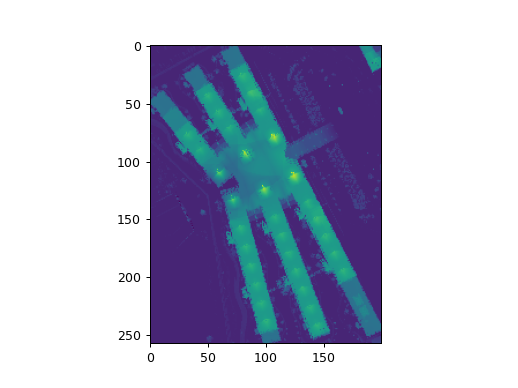

<IPython.core.display.Javascript object>


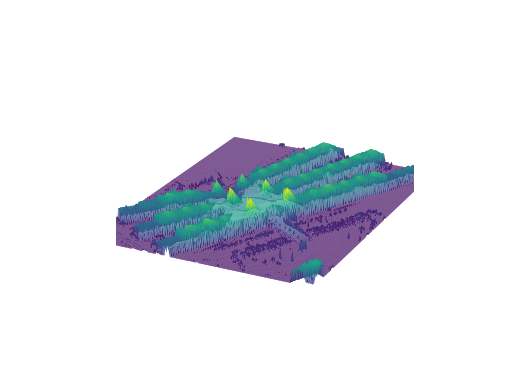

In [4]:
visualizer.lookup('Bolivarplaats 20, 2000 Antwerpen')